# Packages

In [197]:
import numpy as np
import pandas as pd #for loading csv Excel files
import itertools #to merge lists
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl #for plots
from matplotlib import rc, rcParams

# Options for plotting

In [198]:
fontsize=26
legendfontsize=22
font = {'size' : fontsize}
rc('font',**font)
rc('text', usetex=True)
rc('font', family='serif', serif='Computer Modern Roman')

In [199]:
#Color palette accessible to colorblind people (see https://davidmathlogic.com/colorblind/)
lightblue='#1A85FF'
blue='#005AB5'
darkblue='#222255'
purple='#5D3A9B'
magenta='#AA4499'
red='#DC3220'
orange='#E66100'
yellow='#FFC20A'
green='#40B0A6'

colors=[lightblue,blue,darkblue,purple,magenta,red,orange,yellow,green]

# Constants

In [177]:
c=2.99792458*10.**8.*10.**(-3.) #km/s (not m/s)
GeV_to_cmminus1=5.06*10.**13.
GeV_to_g=1.78*10.**(-24.)

# Data dark photon model

In [8]:
potentials=['attractive','repulsive'] 
datadarkphotonmodel=np.array([pd.read_csv('DataDarkPhotonModel/crosssec_'+str(potential)+'.csv',header=-1).values for potential in potentials]) #header=-1 needed to load da a from first line.
avals=np.array(datadarkphotonmodel[0][:,0]) #Same avals for both potentials.
#print(avals) 
uniqueavals=np.unique(avals)
#print(uniqueavals)
bvals=np.array(datadarkphotonmodel[0][:,1]) #Same bvals for both potentials.
#print(bvals) 
uniquebvals=np.unique(bvals)
#print(uniquebvals)
print(len(uniquebvals))
cvals=[datadarkphotonmodel[i][:,2] for i in range(0,len(datadarkphotonmodel))]
#print(cvals) 

1001


# Generate 2D interpolation function c(a,b)

In [190]:
#_____Extract lines in data dark photon model with same bvals (repeat each other)_____
ibvals=np.array([list(itertools.chain.from_iterable(np.argwhere(bvals==uniquebvals[i]))) for i in range(0,len(uniquebvals))])
#print(ibvals[0])
#_____For fixed b interpolate in terms of a: c(a)_____
###Note: Small, negligible differences between linear and cubic interpolation function. Interpolation function might break down when extrapolating to values far outside the range of [a,b]. 
#caint=np.array([[interp1d([avals[k] for k in ibvals[j]],[cvals[i][k] for k in ibvals[j]],kind='linear') for j in range(0,len(ibvals))] for i in range(0,len(potentials))])
caint=np.array([[interp1d([avals[k] for k in ibvals[j]],[cvals[i][k] for k in ibvals[j]],kind='cubic',fill_value='extrapolate') for j in range(0,len(ibvals))] for i in range(0,len(potentials))])
#print(caint)

In [162]:
#_____2D interpolation function c(a,b)_____
def cab(potential,a,b):
    if potential=='attractive':
        caInt=caint[0]
    elif potential=='repulsive':
        caInt=caint[1]
    #_____Evaluate all interpolation functions c(b) at b and interpolate in terms of a: c(a,b)_____
    cavals=[caInt[i](a) for i in range(0,len(caInt))]
    cab=interp1d(uniquebvals,cavals,kind='cubic',fill_value='extrapolate')(b) #,kind='cubic',fill_value='extrapolate'
    return cab
    
for potential in ['attractive']: #['attractive','repulsive']:
    for b in [0.1]: #[0.1,10.,100.,1000.,10000.]
        for a in [avals[0],avals[1],10**(-10.)]:
            print([a,b,cab(potential,a,b)])

[1e-05, 0.1, array(1.10814e-14)]
[1.05925e-05, 0.1, array(1.24335e-14)]
[1e-10, 0.1, array(-5.79385703e-16)]


# sigmaT(v)

In [214]:
def sigmaT(potential,alphaX,mX,mphi,v):
    a=(1/(2.*alphaX))*(v/c) #Divide by c to make a dimensionless. Ok.
    b=alphaX*(mX/mphi)
    #print('[a,b]='+str([a,b]))
    sigmaT=(16.*np.pi*cab(potential,a,b))/((mX*GeV_to_cmminus1)**2.*(v**2/c**2.)) #cm**2
    return sigmaT

def sigmaT_over_m(potential,alphaX,mX,mphi,v):
    sigmaT_over_m=sigmaT(potential,alphaX,mX,mphi,v)/(mX*GeV_to_g) #cm**2/g
    return sigmaT_over_m

def sigmaT_times_m2(potential,alphaX,mX,mphi,v):
    sigmaT_times_m2=sigmaT_over_m(potential,alphaX,mX,mphi,v)*mX**3. #cm**2/g*GeV**3.
    return sigmaT_times_m2

for potential in ['attractive']: #['attractive','repulsive']:
    for alphaX in [10.**(-2.)]:
        for mX in [200]: #GeV
            for mphi in [10**(-3.)]: #GeV.
                for v in [1000]: #km/s
                    print('sigmaT [cm^2]='+str(sigmaT(potential,alphaX,mX,mphi,v)))
                    print('sigmaT/m [cm^2/g]='+str(sigmaT_over_m(potential,alphaX,mX,mphi,v)))
                    print('sigmaT*m [(cm^2/g) GeV^3]='+str(sigmaT_times_m2(potential,alphaX,mX,mphi,v)))

sigmaT [cm^2]=5.269668738050891e-20
sigmaT/m [cm^2/g]=148.02440275423854
sigmaT*m [(cm^2/g) GeV^3]=1184195222.0339084


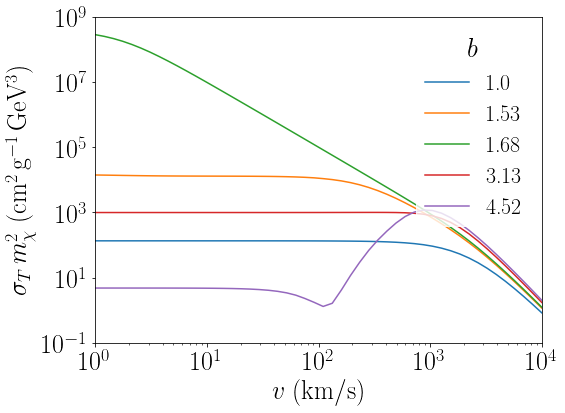

In [222]:
potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.

pl.figure(figsize=(8,6))
for b in [1.00,1.53,1.68,3.13,4.52]:
    mphi=(alphaX*mX)/b
    #print(mphi)
    vvals=np.logspace(np.log10(1.),np.log10(10.**4.),50)
    sigmavals=[sigmaT_times_m2(potential,alphaX,mX,mphi,v) for v in vvals]
    pl.plot(vvals,sigmavals,label=str(b))

pl.xscale('log')
pl.yscale('log')
pl.xlim([1,10.**4.])
pl.ylim([0.1,10.**9.])
pl.xlabel(r'$v\;{\rm (km/s)}$',fontsize=fontsize) 
pl.ylabel(r'$\sigma_T \, m_{\chi}^{2}\;{\rm (cm^{2}\,g^{-1}\,GeV^{3})}$',fontsize=fontsize) 
pl.legend(title=r'$b$',loc='upper right',edgecolor='white',fontsize=legendfontsize)
pl.show() #Ok. In accordance with Fig. 3 in Sean's paper 1302.3898.